In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import pyAMI.client
import pyAMI_nika2
import fkplotlib

fkplotlib.use_txfonts()
client = pyAMI.client.Client("nika2")

In [2]:
def submit_mql_query(mql, entity="CLUSTER"):
    """
    Submits a MQL query to AMI.

    Parameters
    ----------
    mql : str
        An MQL query. Can be generated using the AMI web 
        interface, by doing the box selection thing and clicking 
        ``More > View MQL query``

    entity : str
        What you are searching for, one of
        ``CLUSTER`` or ``SCAN``

    Returns
    -------
    `pandas.DataFrame`
        A DataFrame of AMI entries matching your query.
        Rows are database entries, and columns are attributes
        (e.g., RA, DEC, z, etc for a cluster; 
        name, tau, source for a scan, etc).
    """

    result = client.execute(
        'SearchQuery -catalog="nika2:production"'
        + f'-entity="{entity.upper()}" -mql="{mql}"',
        format="dom_object",
    ).get_rows()

    return pd.DataFrame(result)


In [3]:
def get_cluster_scans(cluster):
    """
    Get a table with all scans realized on a given cluster.

    Parameters
    ----------
    cluster : str
        A cluster's shortName (e.g. "ACTJ0215", "PSZ2G144")

    Returns
    -------
    `pandas.DataFrame`
        DataFrame containing one entry per scan,
        with all AMI's scan properties as columns.
    """

    mql = (
        f"SELECT * WHERE [`nika2:production`.`CLUSTER`.`shortName` = '{cluster}']"
        + "LIMIT 1000 OFFSET 0"
    )

    scans = submit_mql_query(mql, entity="SCAN")

    return pd.DataFrame(scans)

In [4]:
scans_actj0215 = get_cluster_scans("ACTJ0215")

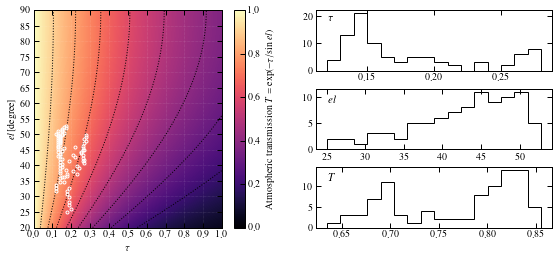

In [10]:
tau, el = np.meshgrid(np.linspace(0, 1, 1000), np.linspace(20, 90, 1000))
f = np.exp(-tau / np.sin(el * u.deg))

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
fkplotlib.ax_bothticks(ax)
im = ax.imshow(
    f,
    extent=[tau.min(), tau.max(), el.min(), el.max()],
    origin="lower",
    aspect="auto",
    cmap="magma",
    vmin=0.0, vmax=1.0
)
cs = ax.contour(
    f,
    extent=[tau.min(), tau.max(), el.min(), el.max()],
    colors="k",
    linestyles=":",
    levels=np.arange(0.2, 1.1, 0.1),
)

ax.set_xticks(np.arange(0.0, 1.1, 0.1))
ax.set_yticks(np.arange(20, 95, 5))
ax.grid(ls=":", color="w", alpha=0.3)
cb = fig.colorbar(im)
cb.set_label(r"Atmospheric transmission $T = \mathrm{exp}(-\tau/\mathrm{sin}\,el)$")
ax.set_xlabel(r"$\tau$")
ax.set_ylabel(r"$el\,\mathrm{[degree]}$")

taus_act = scans_actj0215['tau225'].astype(float)
els_act = scans_actj0215['elevation'].astype(float)
trans_act = np.exp(-taus_act / np.sin(els_act * u.deg.to('rad')))
ax.plot(taus_act, els_act, ".", mec="w", mfc="#00000000")

ax = fig.add_subplot(322)
fkplotlib.ax_bothticks(ax)
ax.hist(taus_act, color="k", histtype="step", bins=16)
ax.text(0.05, 0.95, r"$\tau$", fontsize=11,
        transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')

ax = fig.add_subplot(324)
fkplotlib.ax_bothticks(ax)
ax.hist(els_act, color="k", histtype="step", bins=16)
ax.text(0.05, 0.9, r"$el$", fontsize=11,
        transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')

ax = fig.add_subplot(326)
fkplotlib.ax_bothticks(ax)
ax.hist(trans_act, color="k", histtype="step", bins=16)
ax.text(0.05, 0.9, r"$T$", fontsize=11,
        transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')

fig.align_labels()
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.3)
fig.savefig("scans.pdf")

In [6]:
trans_act.max()

0.8555304209990654